In [1]:
# Core
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# TensorFlow / Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers

# Metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

# For reproducibility
np.random.seed(42)
tf.random.set_seed(42)
SEED = 42

from google.colab import drive
drive.mount('/content/drive')

print("TensorFlow version:", tf.__version__)


Mounted at /content/drive
TensorFlow version: 2.19.0


In [2]:
# NPZ_PATH = "/content/drive/MyDrive/Summer 2025/APS 360/ML_processed_data.npz"  # <- round 1 data
NPZ_PATH = "/content/drive/MyDrive/Summer 2025/APS 360/Group 31 Project/ML_processed_data_APS360_FFTMAG_newCSV.npz"  # <- round 2 data
# NPZ_PATH = '/content/drive/My Drive/Colab Notebooks/Group 31 Project/ML_processed_data_APS360_FFTMAG_newCSV.npz'

# Load .npz file
data = np.load(NPZ_PATH)

# Expected keys: 'X' for features, 'y' for labels
X = data['X']   # shape: (n_samples, 197)
y = data['y']   # shape: (n_samples, )

print("Feature matrix shape:", X.shape)
print("Target vector shape:", y.shape)

# Quick peek at first sample
print("\nFirst feature vector (truncated):", X[0][:])
print("First target (mass):", y[0])

print(len(X[0][:]))


Feature matrix shape: (204953, 197)
Target vector shape: (204953, 1)

First feature vector (truncated): [ 5.99144772e-03  4.04889975e-03  2.47844476e-02  6.73505198e-03
  8.93446617e-03  5.92475757e-03  3.04124393e-02  1.10057006e-02
  9.69329849e-03  5.77636249e-03  2.59853620e-02  8.44423473e-03
  1.29144266e-02  5.61637990e-03  2.08779573e-02  3.92108085e-03
  1.41834086e-02  8.97900108e-03  1.73088200e-02  1.03528344e-03
  1.23559618e-02  1.68615710e-02  1.70987751e-02  1.20287796e-03
  1.08371796e-02  2.55503692e-02  1.80457588e-02  1.99699588e-03
  1.30104581e-02  3.07558775e-02  1.44252200e-02  3.05428286e-03
  1.75643228e-02  3.07506770e-02  1.96550204e-03  3.39369336e-03
  1.92248300e-02  2.85967533e-02  2.07989421e-02  3.05264839e-03
  1.65843070e-02  2.88891364e-02  4.31774855e-02  2.36767018e-03
  2.21909657e-02  3.12412120e-02  5.31905368e-02  2.34432775e-03
  3.58118229e-02  3.19874957e-02  4.36897241e-02  3.37923854e-03
  4.25694361e-02  2.89483666e-02  2.06384771e-02  4

In [3]:

from sklearn.model_selection import StratifiedShuffleSplit

# 1) Build stratification labels from y (equal-frequency bins)
#    Adjust q (e.g., 5, 10, 20) to control how fine the bins are.
q = 10
y = np.asarray(y).ravel()
y_strat = pd.qcut(y, q=q, duplicates="drop")  # equal-sized bins
y_strat_codes = y_strat.codes  # integer labels for stratification

# 2) First stratified split: Train (60%) vs Temp (40%)
sss1 = StratifiedShuffleSplit(n_splits=1, test_size=0.4, random_state=SEED)
(train_idx, temp_idx), = sss1.split(X, y_strat_codes)

X_train, y_train = X[train_idx], y[train_idx]
X_temp,  y_temp  = X[temp_idx],  y[temp_idx]
y_strat_temp = y_strat_codes[temp_idx]

# 3) Second stratified split on the TEMP subset: Val (20%) vs Test (20%)
sss2 = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=SEED)
(val_idx_rel, test_idx_rel), = sss2.split(X_temp, y_strat_temp)

X_val,  y_val  = X_temp[val_idx_rel],  y_temp[val_idx_rel]
X_test, y_test = X_temp[test_idx_rel], y_temp[test_idx_rel]

print("Train:", X_train.shape, " Val:", X_val.shape, " Test:", X_test.shape)

# 4) Scale features using only the TRAIN set
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_val_s   = scaler.transform(X_val)
X_test_s  = scaler.transform(X_test)

# 5) Ensure 1-D float targets
y_train = np.asarray(y_train, dtype="float32").ravel()
y_val   = np.asarray(y_val,   dtype="float32").ravel()
y_test  = np.asarray(y_test,  dtype="float32").ravel()


Train: (122971, 197)  Val: (40991, 197)  Test: (40991, 197)


In [ ]:
unique_masses = np.unique(np.concatenate([y_train, y_val, y_test]))
rows = []
for mass in unique_masses:
    rows.append({
        "Mass (kg)": mass,
        "Train Count": np.sum(y_train == mass),
        "Val Count":   np.sum(y_val == mass),
        "Test Count":  np.sum(y_test == mass)
    })

df_counts = pd.DataFrame(rows)
print(df_counts.to_string(index=False))

   Mass (kg)  Train Count  Val Count  Test Count
 3084.399902         3927       1340        1311
 3280.000000         2629        839         876
 3890.000000        16517       5512        5504
 3990.000000        12347       4116        4115
 4082.300049         3289       1096        1096
 4320.000000        20680       6893        6894
 4630.000000        15258       5086        5087
 4650.000000        21903       7301        7301
 5210.000000        16173       5392        5391
10759.200195         9607       3209        3225
13489.799805          641        207         191


In [ ]:
BEST = {"dropout": 0.3, "l2": 0.003, "lr": 0.001, "batch": 128}
input_dim = X_train_s.shape[1]

def build_model(input_dim, dropout=BEST["dropout"], l2=BEST["l2"], lr=BEST["lr"]):
    reg = regularizers.l2(l2)
    inputs = keras.Input(shape=(input_dim,))
    x = layers.Dense(256, activation="relu", kernel_regularizer=reg)(inputs)
    x = layers.Dropout(dropout)(x)
    x = layers.Dense(128, activation="relu", kernel_regularizer=reg)(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Dense(64, activation="relu", kernel_regularizer=reg)(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Dense(32, activation="relu", kernel_regularizer=reg)(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Dense(16, activation="relu", kernel_regularizer=reg)(x)
    x = layers.Dropout(dropout)(x)
    outputs = layers.Dense(1, dtype="float32")(x)
    model = keras.Model(inputs, outputs)
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        loss="mse",
        metrics=[keras.metrics.RootMeanSquaredError(name="rmse")]
    )
    return model

model = build_model(input_dim)

model.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 197)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 256)            │        50,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_40 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_41 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_42 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_43 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_44 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 94,465 (369.00 KB)

 Trainable params: 94,465 (369.00 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
callbacks = [
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_rmse", factor=0.5, patience=8, min_lr=1e-5, mode="min", verbose=1
    ),
    keras.callbacks.EarlyStopping(
        monitor="val_rmse", patience=20, restore_best_weights=True, min_delta=50, mode="min"
    )
]

history = model.fit(
    X_train_s, y_train,
    validation_data=(X_val_s, y_val),
    epochs=75,
    batch_size=BEST["batch"],
    callbacks=callbacks,
    verbose=1
)


Epoch 1/75
961/961 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - loss: 9806935.0000 - rmse: 3044.0076 - val_loss: 1424887.7500 - val_rmse: 1193.6855 - learning_rate: 0.0010
Epoch 2/75
961/961 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 2911739.2500 - rmse: 1706.2750 - val_loss: 900399.1250 - val_rmse: 948.8920 - learning_rate: 0.0010
Epoch 3/75
961/961 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 2595815.5000 - rmse: 1611.1029 - val_loss: 793233.7500 - val_rmse: 890.6350 - learning_rate: 0.0010
Epoch 4/75
961/961 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 2439918.0000 - rmse: 1561.9828 - val_loss: 896906.1875 - val_rmse: 947.0496 - learning_rate: 0.0010
Epoch 5/75
961/961 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 2307610.2500 - rmse: 1519.0442 - val_loss: 602284.5625 - val_rmse: 776.0676 - learning_rate: 0.0010
Epoch 6/75
961/961 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 2223681.5000 - rmse: 1491.1818 - val_loss: 747792.1875 - val_rmse: 864.7474 - learning_rate: 0.0010
Epoch 7/75
961/961 ━━━━━━━━━━━━━━━━━━

In [4]:
MODEL_PATH = "/content/drive/MyDrive/Summer 2025/APS 360/Group 31 Project/DNN.keras"
#model.save(MODEL_PATH)

In [5]:
model = keras.models.load_model(MODEL_PATH, compile=False)

VAL — RMSE: 490.78 kg | slope: 0.898 | intercept: 283.17


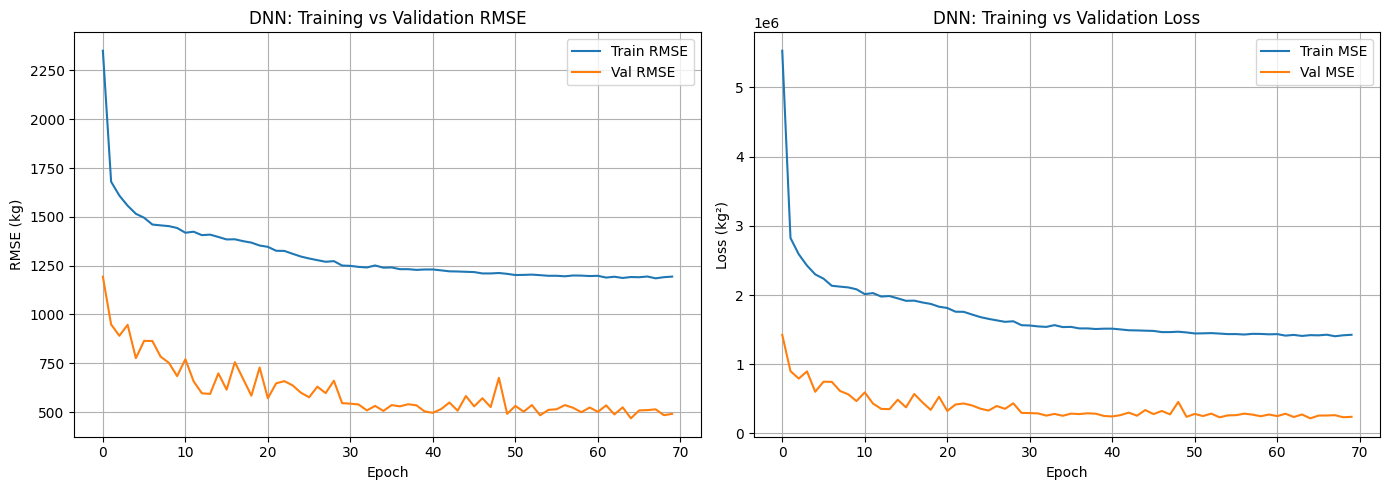

In [ ]:
y_val_pred = model.predict(X_val_s, verbose=0).ravel()
val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
m_val, b_val = np.polyfit(y_val, y_val_pred, 1)
print(f"VAL — RMSE: {val_rmse:.2f} kg | slope: {m_val:.3f} | intercept: {b_val:.2f}")

fig, axes = plt.subplots(1, 2, figsize=(14,5))
axes[0].plot(history.history["rmse"], label="Train RMSE")
axes[0].plot(history.history["val_rmse"], label="Val RMSE")
axes[0].set_title("DNN: Training vs Validation RMSE"); axes[0].set_xlabel("Epoch"); axes[0].set_ylabel("RMSE (kg)"); axes[0].legend(); axes[0].grid(True)
axes[1].plot(history.history["loss"], label="Train MSE")
axes[1].plot(history.history["val_loss"], label="Val MSE")
axes[1].set_title("DNN: Training vs Validation Loss"); axes[1].set_xlabel("Epoch"); axes[1].set_ylabel("Loss (kg²)"); axes[1].legend(); axes[1].grid(True)
plt.tight_layout(); plt.show()

In [ ]:
# ----- VALIDATION -----
y_val_pred = model.predict(X_val_s, verbose=0).ravel()
val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
m_val, b_val = np.polyfit(y_val, y_val_pred, 1)
print(f"VALIDATION — RMSE: {val_rmse:.2f} kg | slope: {m_val:.3f} | intercept: {b_val:.2f}")

abs_err_val = np.abs(y_val_pred - y_val)
print(f"Validation: within 10 kg:   {(abs_err_val <= 10).mean()*100:6.2f}%")
print(f"Validation: within 100 kg:  {(abs_err_val <= 100).mean()*100:6.2f}%")
print(f"Validation: within 1000 kg: {(abs_err_val <= 1000).mean()*100:6.2f}%")
ape_val = abs_err_val / np.clip(np.abs(y_val), 1e-9, None)
print("Validation APE ≤ thresholds:")
for t in [1, 2, 5, 10, 15, 20, 25, 30]:
    print(f"  ≤{t:>2}%: {(ape_val <= t/100).mean()*100:6.2f}%")

print()  # spacer

VALIDATION — RMSE: 466.44 kg | slope: 0.903 | intercept: 264.43
Validation: within 10 kg:     1.79%
Validation: within 100 kg:   16.73%
Validation: within 1000 kg:  97.69%
Validation APE ≤ thresholds:
  ≤ 1%:   6.95%
  ≤ 2%:  13.82%
  ≤ 5%:  39.59%
  ≤10%:  76.97%
  ≤15%:  89.97%
  ≤20%:  97.08%
  ≤25%:  99.07%
  ≤30%:  99.62%



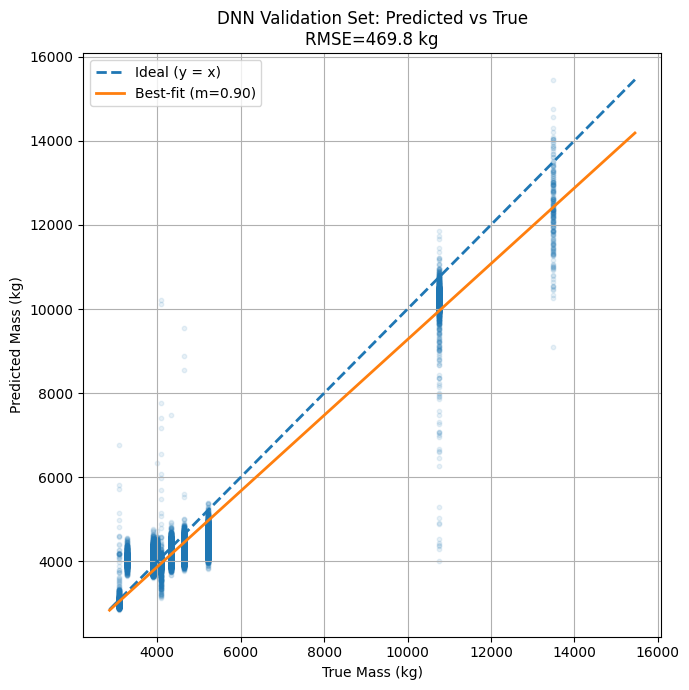

In [ ]:
# --- Validation scatter: Pred vs True ---
y_true = np.asarray(y_val).ravel()
y_pred = np.asarray(y_val_pred).ravel()
mask = np.isfinite(y_true) & np.isfinite(y_pred)
y_true = y_true[mask]; y_pred = y_pred[mask]

# Metrics for annotation
rmse_val = np.sqrt(mean_squared_error(y_true, y_pred))
m_val, b_val = np.polyfit(y_true, y_pred, 1)

# Scatter + lines
plt.figure(figsize=(7, 7))
plt.scatter(y_true, y_pred, s=10, alpha=0.1)

lims = [min(y_true.min(), y_pred.min()), max(y_true.max(), y_pred.max())]
xs = np.linspace(lims[0], lims[1], 200)

plt.plot(lims, lims, '--', lw=2, label='Ideal (y = x)')
plt.plot(xs, m_val*xs + b_val, lw=2, label=f'Best-fit (m={m_val:.2f})')

plt.xlabel('True Mass (kg)')
plt.ylabel('Predicted Mass (kg)')
plt.title(f'DNN Validation Set: Predicted vs True\nRMSE={rmse_val:.1f} kg')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
print(np.mean(ape_test)*100)
print(np.median(ape_test)*100)

7.3074036
6.1575656


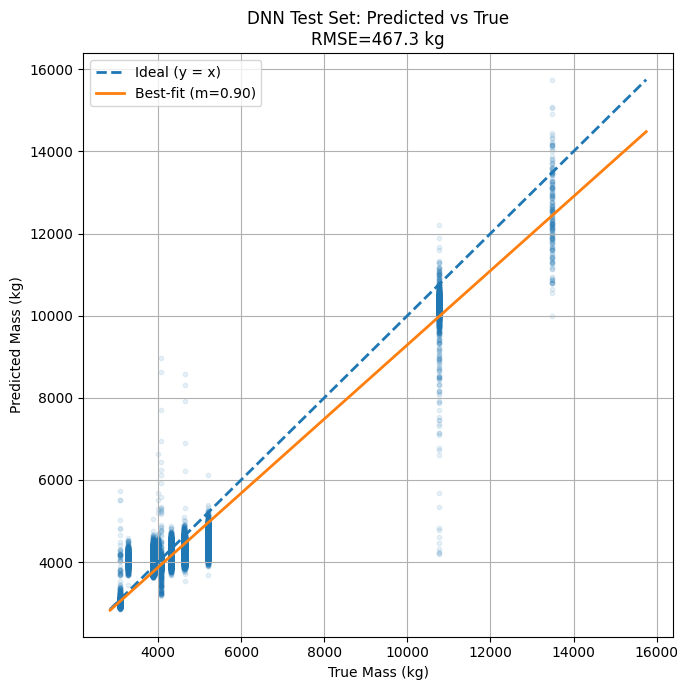

In [ ]:
y_true = np.asarray(y_test).ravel()
y_pred = np.asarray(y_test_pred).ravel()
mask = np.isfinite(y_true) & np.isfinite(y_pred)
y_true = y_true[mask]; y_pred = y_pred[mask]
# Metrics for annotation
rmse_test = np.sqrt(mean_squared_error(y_true, y_pred))
m_test, b_test = np.polyfit(y_true, y_pred, 1)


# Scatter + lines
plt.figure(figsize=(7, 7))
plt.scatter(y_true, y_pred, s=10, alpha=0.1)

lims = [min(y_true.min(), y_pred.min()), max(y_true.max(), y_pred.max())]
xs = np.linspace(lims[0], lims[1], 200)

plt.plot(lims, lims, '--', lw=2, label='Ideal (y = x)')
plt.plot(xs, m_test*xs + b_test, lw=2, label=f'Best-fit (m={m_test:.2f})')

plt.xlabel('True Mass (kg)')
plt.ylabel('Predicted Mass (kg)')
plt.title(f'DNN Test Set: Predicted vs True\nRMSE={rmse_test:.1f} kg')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Accuracy within relative-error thresholds:
 ≤  1%:   6.98%
 ≤  2%:  13.75%
 ≤  5%:  39.64%
 ≤ 10%:  76.58%
 ≤ 15%:  89.76%
 ≤ 20%:  97.04%
 ≤ 25%:  98.88%
 ≤ 30%:  99.55%

MAPE:       7.31%
Median APE: 6.16%


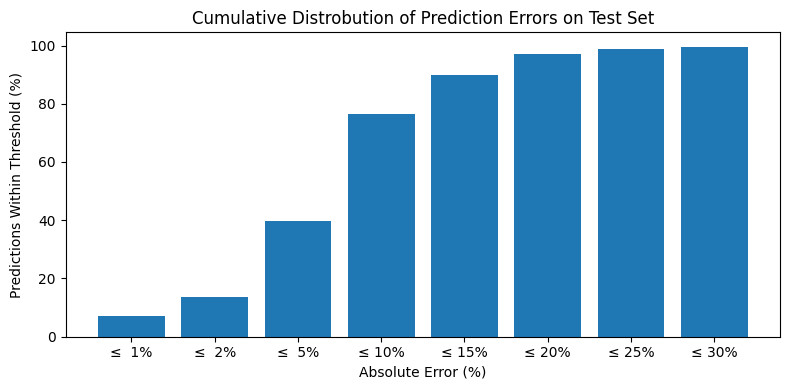

In [ ]:
thresholds = [1, 2, 5, 10, 15, 20, 25, 30]  # tweak as you like

ape = ape_test
rows = []
for t in thresholds:
    pct = (ape <= (t/100.0)).mean() * 100.0
    rows.append((f"≤ {t:>2}%", pct))

# Summary stats
mape = np.mean(ape) * 100.0
med_ape = np.median(ape) * 100.0

print("Accuracy within relative-error thresholds:")
for name, pct in rows:
    print(f"{name:>6}: {pct:6.2f}%")

print(f"\nMAPE:       {mape:.2f}%")
print(f"Median APE: {med_ape:.2f}%")

# Optional: bar chart
labels = [r[0] for r in rows]
values = [r[1] for r in rows]

plt.figure(figsize=(8,4))
plt.bar(labels, values)
#plt.axhline(50, linestyle='--', linewidth=1)  # reference line
plt.ylabel("Predictions Within Threshold (%)")
plt.xlabel("Absolute Error (%)")
plt.title("Cumulative Distrobution of Prediction Errors on Test Set")
plt.tight_layout()
plt.show()

/tmp/ipython-input-3700538918.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(test_data, labels=labels_test, showfliers=False, whis=[5, 95])


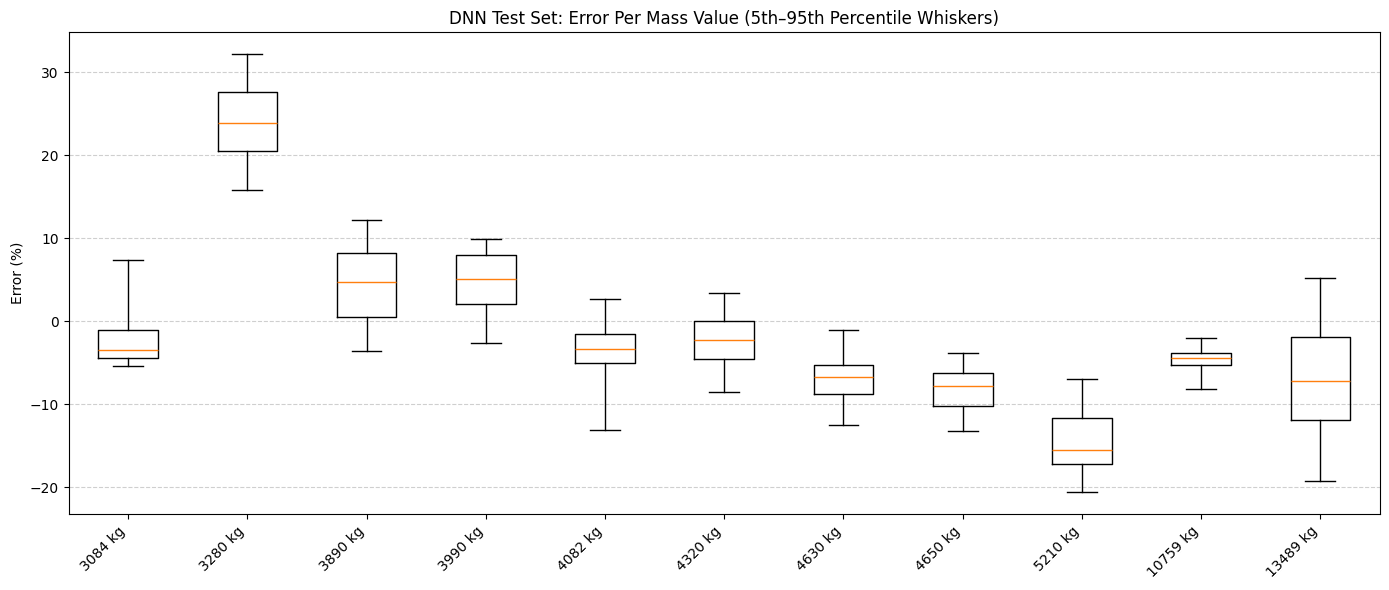

In [ ]:
ape_test = ((y_test_pred - y_test) / np.clip(np.abs(y_test), 1e-9, None)) * 100

# Group APE values by each unique mass in the test set
unique_masses_test = np.unique(y_test)
test_data = [ape_test[y_test == mass] for mass in unique_masses_test]
labels_test = [f"{int(mass)} kg" for mass in unique_masses_test]

# Plot boxplot
plt.figure(figsize=(14,6))
plt.boxplot(test_data, labels=labels_test, showfliers=False, whis=[5, 95])
plt.xticks(rotation=45, ha="right")
plt.ylabel("Error (%)")
plt.title("DNN Test Set: Error Per Mass Value (5th–95th Percentile Whiskers)")
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()